# DREAMS database inspection

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from tqdm import tqdm

project_root = os.path.abspath('..')
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset
from sleeprnn.data.dataset import KEY_EEG, KEY_N2_PAGES, KEY_ALL_PAGES, KEY_MARKS
from sleeprnn.data.utils import seq2stamp, stamp2seq, seq2stamp_with_pages, power_spectrum
from sleeprnn.data import utils
from sleeprnn.detection.metrics import by_sample_confusion, by_sample_iou, by_event_confusion, matching
from sleeprnn.common import constants, pkeys, checks

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [19]:
dataset_name = constants.DREAMS_SS_NAME
dataset = load_dataset(dataset_name)

Train size: 4. Test size: 3
Train subjects: 
 [1, 3, 6, 8]
Test subjects: 
 [2, 5, 7]
Dataset dreams_ss with 7 patients.
Loading from checkpoint... Loaded
Global STD: 18.343672


## Checking general numbers

In [5]:
print('Sample frequency:', dataset.fs)
print('Page duration and size:', dataset.page_duration, dataset.page_size)
print('Registers ids:', dataset.all_ids)
print('Number of loaded registers:', len(dataset.data))
print('')
print('Train set IDs:', dataset.train_ids)
print('Test set IDs:', dataset.test_ids)

for subject_id in dataset.all_ids:
    single_stamps_all = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
    single_stamps_n2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=constants.N2_RECORD)
    single_n2_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=constants.N2_RECORD)
    single_hypnogram = dataset.get_subject_hypnogram(subject_id)
    center_stamps = single_stamps_all.mean(axis=1)
    stamp_pages = (center_stamps / dataset.page_size).astype(np.int32)
    state_for_stamp = single_hypnogram[stamp_pages]
    values, counts = np.unique(state_for_stamp, return_counts=True)
    
    print('\nSubject %d' % subject_id)
    print('%d pages. %d n2-pages. %d marks. %d n2-marks' % (single_hypnogram.size, single_n2_pages.size, single_stamps_all.shape[0], single_stamps_n2.shape[0]))
    for value, count in zip(values, counts):
        print('%d marks in state %s. ' % (count, value), end='')
    print('')

Sample frequency: 200
Page duration and size: 20 4000
Registers ids: [1, 2, 3, 5, 6, 7, 8]
Number of loaded registers: 7

Train set IDs: [1, 3, 6, 8]
Test set IDs: [2, 5, 7]

Subject 1
90 pages. 54 n2-pages. 52 marks. 52 n2-marks
52 marks in state 2. 

Subject 2
90 pages. 48 n2-pages. 58 marks. 52 n2-marks
52 marks in state 2. 6 marks in state 3. 

Subject 3
90 pages. 56 n2-pages. 5 marks. 5 n2-marks
5 marks in state 2. 

Subject 5
90 pages. 51 n2-pages. 55 marks. 52 n2-marks
52 marks in state 2. 3 marks in state 3. 

Subject 6
90 pages. 53 n2-pages. 70 marks. 62 n2-marks
62 marks in state 2. 4 marks in state 3. 4 marks in state 4. 

Subject 7
90 pages. 61 n2-pages. 18 marks. 16 n2-marks
16 marks in state 2. 1 marks in state 3. 1 marks in state 4. 

Subject 8
90 pages. 67 n2-pages. 48 marks. 48 n2-marks
48 marks in state 2. 


## Distribution of signal

N subjects: 7
Normalizing with IQR
Normalizing with IQR
Normalizing with IQR
Normalizing with IQR
Normalizing with IQR
Normalizing with IQR
Normalizing with IQR


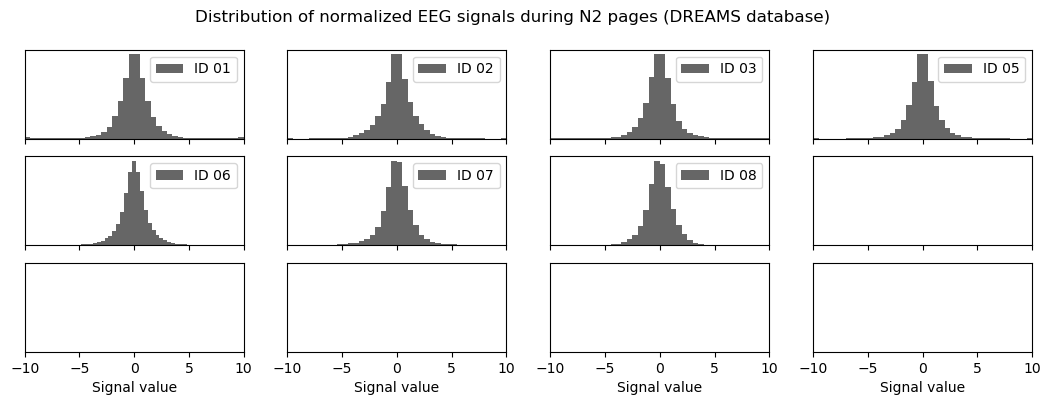

In [6]:
n_ids = len(dataset.all_ids)
print('N subjects:', n_ids)

n_rows = 3
n_cols = 4

fig, ax = plt.subplots(n_rows, n_cols, dpi=100, figsize=(13, 4), sharex=True)
for i, sub_id in enumerate(dataset.all_ids):
    this_row = int(i / n_cols)
    this_col = i - this_row * n_cols
    n2_signal, _ = dataset.get_subject_data(sub_id, normalize_clip=True)
    ax[this_row, this_col].hist(n2_signal.flatten(), label='ID %02d' % sub_id, bins=40, color='k', alpha=0.6)
    ax[this_row, this_col].set_yticks([])
    ax[this_row, this_col].set_xlim([-10, 10])
    # ax[this_row, this_col].set_xlim([-150, 150])
    ax[this_row, this_col].legend(loc='upper right')
    if this_row == n_rows-1:
        ax[this_row, this_col].set_xlabel('Signal value')

for j in range(i + 1, n_rows * n_cols):
    this_row = int(j / n_cols)
    this_col = j - this_row * n_cols
    ax[this_row, this_col].set_yticks([])
    if this_row == n_rows-1:
        ax[this_row, this_col].set_xlabel('Signal value')

fig.suptitle('Distribution of normalized EEG signals during N2 pages (DREAMS database)')
# plt.tight_layout()
plt.show()

## Check one subject

In [7]:
subject_id = 7
show_only_n2 = False

band_pass_freqs = [12, 14]

# -----
channel_name = 'Cz-A1'
task_mode = constants.N2_RECORD
if show_only_n2:
    pages_subset = constants.N2_RECORD
else:
    pages_subset = constants.WN_RECORD

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset)

event_name = dataset.event_name

fs_real = dataset.fs


def filter_stamps(stamps, single_page, page_size):
    pages_list = []
    for i in range(stamps.shape[0]):
        stamp_start_page = stamps[i, 0] // page_size
        stamp_end_page = stamps[i, 1] // page_size

        start_inside = (stamp_start_page == single_page)
        end_inside = (stamp_end_page == single_page)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_page(page_idx):
    fig = plt.figure(figsize=(12, 3), dpi=DPI)
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2])
    
    page_idx = page_idx - 1
    page_chosen = this_pages[page_idx]
    page_state = this_hypnogram[page_chosen]
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    segment_signal = this_signal[page_start:page_end]
    segment_stamps = filter_stamps(this_stamps, page_chosen, dataset.page_size)
    time_axis_real = np.arange(page_start, page_end) / fs_real
    
    gs_idx = 0
    
    # Signal
    y_max = 150
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Subject %d (%s). Page in record: %d. State %s (intervals of 0.5s are shown).' 
                 % (subject_id, dataset_name.upper(), page_chosen, page_state), fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 50
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (%s Hz)' % band_pass_freqs, fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    plt.tight_layout()
    plt.show()

In [8]:
widgets.interact(
    lambda page_idx: plot_page(page_idx),
    page_idx=widgets.IntSlider(min=1,max=this_pages.shape[0],step=1,value=1, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='page_idx', max=88, min=1), Outp…